# Differential regulation of APA under diauxic stress

**Purpose**: To explore the motif configurations around polyA sites differentially regulated when yeast are under diauxic stress.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from paper_utilities import motifs, cleavage
from statsmodels.stats.multitest import multipletests


In [5]:
species = 'saccharomyces_cerevisiae'
config  = 'polyastrength_kmers-6'
kmer    = 6


In [6]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
DATADIR   = os.path.join(PROJECT, 'saccharomyces_cerevisiae', 'analysis', 'dapa')
MOTDIR    = os.path.join(PROJECT, 'saccharomyces_cerevisiae', 'analysis', 'motif_analysis', 'dapa_motifs')
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'differential_apa')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [7]:
## Load model configuration information

with open(os.path.join(RESOURCES, 'polyastrength_configurations.pickle'), mode = 'rb') as handle:
    configurations = pickle.load(handle)

gold_sites = configurations[species][config]['golden_lines']
print("\nNumber of golden sites:", gold_sites)

mot_dis_dir = os.path.join(PROJECT, species, 'analysis', 'motif_analysis', 'motif_disruption', config)
print("\nDirectory containing motif disruption results:", mot_dis_dir)



Number of golden sites: 9725

Directory containing motif disruption results: /projects/b1080/eks/polyadenylation/yeast/saccharomyces_cerevisiae/analysis/motif_analysis/motif_disruption/polyastrength_kmers-6


In [8]:
## Load motif family definitions for S. cerevisiae

scer_definitions = {'patterns' : {}, 'distance' : {}}

# By pattern - we only look at pattern families for 6mers
with open(os.path.join(RESOURCES, f'motif_definitions.scer.6mers.patterns.pickle'), mode = 'rb') as handle:
    scer_definitions['patterns'][6] = pickle.load(handle)
    
scer_definitions['patterns'][5] = {'family':{}}
scer_definitions['patterns'][4] = {'family':{}}

# By Hamming distance
for kmer in [4,5,6]:
    with open(os.path.join(RESOURCES, f'motif_definitions.scer.{kmer}mers.distance.pickle'), mode = 'rb') as handle:
        scer_definitions['distance'][kmer] = pickle.load(handle)


In [9]:
## Load significant motifs for the S. cerevisiae PolyaStrength model

with open(os.path.join(RESOURCES, "polyastrength_motifs.significant_motifs.pickle"), mode = 'rb') as handle:
    significant_motifs = pickle.load(handle)

sigmots = significant_motifs['saccharomyces_cerevisiae']['polyastrength']['polyastrength_kmers-6']
print(f"Significant motifs = {len(sigmots)}")


Significant motifs = 246


In [10]:
with open(os.path.join(RESOURCES, 'polyastrength_motifs.family_profiles.pickle'), mode = 'rb') as handle:
    mfam_importance = pickle.load(handle)
    

In [11]:
## Load previously processed data

with open(os.path.join(OUTDIR, 'dapa_data.significant_proximal_sites.pickle'), mode = 'rb') as handle:
    sig_prox = pickle.load(handle)
    
with open(os.path.join(OUTDIR, 'dapa_data.paired_distal_sites.pickle'), mode = 'rb') as handle:
    sig_dist = pickle.load(handle)
    
print(f"Significant proximal sites: {len(sig_prox)}")
print(f"Significant distal sites  : {len(sig_dist)}")
    

Significant proximal sites: 2976
Significant distal sites  : 2976


In [12]:
boxplot_format = {
    'color'        : 'lightgray',
    'boxprops'     : {'edgecolor' : 'black', 'linewidth' : 0.5},
    'medianprops'  : {'color' : 'black', 'linewidth' : 0.5},
    'whiskerprops' : {'color' : 'black', 'linewidth' : 0.5},
    'capprops'     : {'color' : 'black', 'linewidth' : 0.5},
    'flierprops'   : {'color' : 'black'},
    'showfliers'   : False
}

## ANALYSIS

In [13]:
family_cmap = {
    'A-rich'     : '#2278B5',
    'T-rich'     : '#2FA148',
    'TA/TA-rich' : '#D62A28',
    'Other'      : '#F7F8F8',
    'NA'         : '#F7F8F8',
}

light_cmap = {
    -1: '#548fb3',
    0 : '#d6e4ec', 
    1 : '#f6ddce', 
    2 : '#c56d5f'
}

dark_cmap = {
    -1: '#548fb3',
    0 : '#808080', 
    1 : '#f6ddce', 
    2 : '#c56d5f'
}

### Identify motif family peak regions

#### Define optimal configuration of motifs based on peak definition plots

In [14]:
ideal_mot_config = {
    'EE' : {
        'motifs' : sorted(set(itertools.chain.from_iterable([[m for m in scer_definitions['distance'][6]['priority'][mfam] if (m in sigmots)] for mfam in ['TA/TA-rich_d0','TA/TA-rich_d1','TA/TA-rich_d2']]))),
        'region' : (-90,-25),
    },
    'PE' : {
        'motifs' : sorted(set(itertools.chain.from_iterable([[m for m in scer_definitions['distance'][6]['priority'][mfam] if (m in sigmots)] for mfam in ['A-rich_d0','A-rich_d1','A-rich_d2']]))),
        'region' : (-25,-15),
    },
    'UF' : {
        'motifs' : sorted(set(itertools.chain.from_iterable([[m for m in scer_definitions['distance'][6]['priority'][mfam] if (m in sigmots)] for mfam in ['T-rich_d0','T-rich_d1','T-rich_d2']]))),
        'region' : (-15,-6),
    },
    'DF' : {
        'motifs' : sorted(set(itertools.chain.from_iterable([[m for m in scer_definitions['distance'][6]['priority'][mfam] if (m in sigmots)] for mfam in ['T-rich_d0','T-rich_d1','T-rich_d2']]))),
        'region' : (2,15),
    },
}


## Enriched motifs in stress-regulated polyA sites

### Proximal sites

#### Tabulate motif positions and frequency in key regions

In [15]:
sig_prox['idxs_EE'] = sig_prox['sequence'].apply(lambda x : motifs.count_motifs(x[:250], ideal_mot_config['EE']['motifs'], overlapping = False, preference = 'max', method = 'equal', count_only = False, index_only = True))
sig_prox['idxs_PE'] = sig_prox['sequence'].apply(lambda x : motifs.count_motifs(x[:250], ideal_mot_config['PE']['motifs'], overlapping = False, preference = 'max', method = 'equal', count_only = False, index_only = True))
sig_prox['idxs_UF'] = sig_prox['sequence'].apply(lambda x : motifs.count_motifs(x[:250], ideal_mot_config['UF']['motifs'], overlapping = False, preference = 'max', method = 'equal', count_only = False, index_only = True))
sig_prox['idxs_DF'] = sig_prox['sequence'].apply(lambda x : 250 + motifs.count_motifs(x[250:], ideal_mot_config['DF']['motifs'], overlapping = False, preference = 'min', method = 'equal', count_only = False, index_only = True))


In [16]:
sig_prox['count_EE'] = sig_prox.apply(lambda row : np.sum([((row['ctr_cleavage']+ideal_mot_config['EE']['region'][0]) <= x <= (row['ctr_cleavage']+ideal_mot_config['EE']['region'][1])) for x in row['idxs_EE']]), axis = 1)
sig_prox['count_PE'] = sig_prox.apply(lambda row : np.sum([((row['ctr_cleavage']+ideal_mot_config['PE']['region'][0]) <= x <= (row['ctr_cleavage']+ideal_mot_config['PE']['region'][1])) for x in row['idxs_PE']]), axis = 1)
sig_prox['count_UF'] = sig_prox.apply(lambda row : np.sum([((row['ctr_cleavage']+ideal_mot_config['UF']['region'][0]) <= x <= (row['ctr_cleavage']+ideal_mot_config['UF']['region'][1])) for x in row['idxs_UF']]), axis = 1)
sig_prox['count_DF'] = sig_prox.apply(lambda row : np.sum([((row['ctr_cleavage']+ideal_mot_config['DF']['region'][0]) <= x <= (row['ctr_cleavage']+ideal_mot_config['DF']['region'][1])) for x in row['idxs_DF']]), axis = 1)


#### Motif counts in each region by usage group

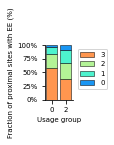

Chi2 test for independence across stress groups
	Groups [0, 2]	2.61E-16


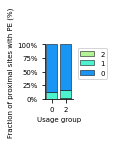

Chi2 test for independence across stress groups
	Groups [0, 2]	2.80E-02


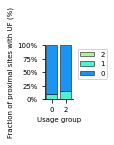

Chi2 test for independence across stress groups
	Groups [0, 2]	6.89E-03


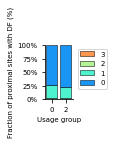

Chi2 test for independence across stress groups
	Groups [0, 2]	2.73E-01


In [17]:
cap = 3
groups = [0,2]

for (cvar,ylim,ytickint) in zip([c for c in sig_prox.columns if (c.startswith('count_'))], [100,20,20,40], [25,5,5,10]):
    
    mvar = cvar.replace('count_','maxcount_')
    
    sig_prox[mvar] = sig_prox[cvar]
    sig_prox.loc[sig_prox[cvar] > cap, mvar] = cap
    
    cdata = sig_prox.loc[sig_prox['sigbinL'].isin(groups)].groupby(['sigbinL',mvar]).size().reset_index(name = 'counts')
    cdata['prop'] = cdata['counts'] / cdata.groupby('sigbinL')['counts'].transform('sum') * 100

    ccounts = cdata.pivot(index = 'sigbinL', columns = mvar, values = 'prop').fillna(0)

    fig,ax = plt.subplots(1,1, figsize = (0.5,1))

    labels = ccounts.index.astype(str).values
    bottoms = np.zeros((len(ccounts)))
    color_list = sns.color_palette('rainbow', cap+1)

    for c in ccounts.columns[::-1]:
        heights = ccounts[[c]].to_numpy().flatten()
        ax.bar(labels, heights, bottom = bottoms, label = c, color = color_list[c], edgecolor = 'black', linewidth = 0.5)
        bottoms = bottoms + heights
    
    ax.set_ylim(0,100)
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))

    ax.set_xlabel("Usage group")
    ax.set_ylabel(f"Fraction of proximal sites with {cvar.split('_')[1]} (%)")

    ax.legend(bbox_to_anchor = (1.05,1))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig(os.path.join(OUTDIR, f'presence_elements.by_stress.proximal_sites.{mvar}.group_{groups[0]}_vs_{groups[1]}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()


    print("Chi2 test for independence across stress groups")

    cwide = cdata.pivot(index = mvar, columns = 'sigbinL', values = 'counts').fillna(0).to_numpy()
    print(f"\tGroups {groups}\t{st.chi2_contingency(cwide)[1]:.02E}")


#### Individual motif enrichment

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-90, -25)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
     testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
190     TATATA        -0.556490         6.751355  0.000692
1500    CATCTA        -2.128167         4.592709  0.049875


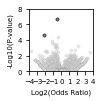

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-25, -15)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


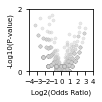

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-15, -6)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


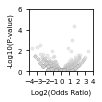

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (2, 15)

 Enriched in ALT group: 2
    testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
190    TATATA         2.661208        13.010252  2.769836e-10
191    ATATAT         2.359160        11.543282  4.058768e-09

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


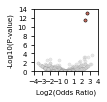

(9845, 12)


In [18]:
kmer = 6
site = 'proximal'
group = 'dapa'
ref_group = 0
alt_group = 2

region_results = []
regions = [v['region'] for k,v in ideal_mot_config.items()]

for region in regions:
    
    ## Load and process data

    dt = (pd.read_csv(os.path.join(MOTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_{region[0]}_{region[1]}.txt'), sep = "\t")
          .replace([np.inf, -np.inf], np.nan).dropna())
    
    dt['odds_ratio_log2'] = np.log2(dt['odds_ratio'])
    dt['pvalue_minlog10'] = -1 * np.log10(dt['pvalue'])
    
    dt['qvalue'] = multipletests(dt['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]
    dt['qvalue_minlog10']  = -1 * np.log10(dt['qvalue'])
    
    dt = dt.replace([np.inf, -np.inf], np.nan).dropna()
    region_results.append(dt)
    
    
    ## Make volcano plot
    
    fig,ax = plt.subplots(1,1, figsize = (1.15,1.15))
    
    sns.scatterplot(data = dt,  x = 'odds_ratio_log2', y = 'pvalue_minlog10', 
                    s = 10, color = 'lightgray', edgecolor = 'darkgray', alpha = 0.5, 
                    rasterized = True, ax = ax)
    
    xlim = math.ceil(max(abs(dt['odds_ratio_log2'])))
    ax.set_xlim((-xlim,xlim))
    ax.xaxis.set_major_locator(MultipleLocator(1))

    ax.set_ylim(0,math.ceil(max(dt['pvalue_minlog10'])/ 2) * 2)
    ax.yaxis.set_major_locator(MultipleLocator(2))
    
    ax.set_xlabel("Log2(Odds Ratio)")
    ax.set_ylabel("-Log10(P-value)")

    ## Annotate plots with significant motifs
    
    print("\nRegion:", region)
    
    cond_sig = (dt['qvalue'] < 0.05)
    pos_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] > 0)]
    neg_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] < 0)]
    
    print("\n Enriched in ALT group:", alt_group)
    print(pos_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    print("\n Enriched in REF group:", ref_group)
    print(neg_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    for i,dtrow in dt.loc[cond_sig].iterrows():
        
        if (dtrow['odds_ratio_log2'] > 0):
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[alt_group], edgecolor = 'black', linewidths = 0.5)
        else:
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[ref_group], edgecolor = 'black', linewidths = 0.5)

    plt.savefig(os.path.join(OUTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_scatter_{region}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()

dapa_results = pd.concat(region_results, ignore_index = True, sort = False)
print(dapa_results.shape)



Region: (-90, -25)

 Enriched in ALT group: 2
    testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
546     GAAGA         0.933996         3.816822  0.019516

 Enriched in REF group: 0
    testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
175     ATATA        -0.430977         6.909106  0.000126
174     TATAT        -0.392747         5.607001  0.001266
190     GTATA        -0.624359         5.058774  0.002981
189     TGTAT        -0.616038         4.717100  0.004587
182     ACATA        -0.591337         4.649793  0.004587
322     TGTAC        -0.947109         3.990203  0.017456
202     ATGTA        -0.535820         3.828705  0.019516
181     TACAT        -0.527605         3.685807  0.021454
677     CATAC        -0.865716         3.678799  0.021454
201     TATGT        -0.523677         3.354152  0.041187


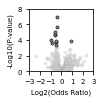

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-25, -15)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


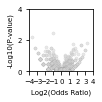

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-15, -6)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


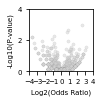

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (2, 15)

 Enriched in ALT group: 2
    testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
175     ATATA         1.731647        12.150062  7.028903e-10
174     TATAT         1.570260        11.828667  7.366347e-10
193     TAAAT         2.099969         4.791565  5.348887e-03
182     ACATA         1.785769         3.992710  2.524522e-02

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


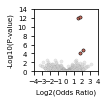

(3733, 12)


In [19]:
kmer = 5
site = 'proximal'
group = 'dapa'
ref_group = 0
alt_group = 2

region_results = []
regions = [v['region'] for k,v in ideal_mot_config.items()]

for region in regions:
    
    ## Load and process data

    dt = (pd.read_csv(os.path.join(MOTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_{region[0]}_{region[1]}.txt'), sep = "\t")
          .replace([np.inf, -np.inf], np.nan).dropna())
    
    dt['odds_ratio_log2'] = np.log2(dt['odds_ratio'])
    dt['pvalue_minlog10'] = -1 * np.log10(dt['pvalue'])
    
    dt['qvalue'] = multipletests(dt['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]
    dt['qvalue_minlog10']  = -1 * np.log10(dt['qvalue'])
    
    dt = dt.replace([np.inf, -np.inf], np.nan).dropna()
    region_results.append(dt)
    
    
    ## Make volcano plot
    
    fig,ax = plt.subplots(1,1, figsize = (1.15,1.15))
    
    sns.scatterplot(data = dt,  x = 'odds_ratio_log2', y = 'pvalue_minlog10', 
                    s = 10, color = 'lightgray', edgecolor = 'darkgray', alpha = 0.5, 
                    rasterized = True, ax = ax)
    
    xlim = math.ceil(max(abs(dt['odds_ratio_log2'])))
    ax.set_xlim((-xlim,xlim))
    ax.xaxis.set_major_locator(MultipleLocator(1))

    ax.set_ylim(0,math.ceil(max(dt['pvalue_minlog10'])/ 2) * 2)
    ax.yaxis.set_major_locator(MultipleLocator(2))
    
    ax.set_xlabel("Log2(Odds Ratio)")
    ax.set_ylabel("-Log10(P-value)")

    ## Annotate plots with significant motifs
    
    print("\nRegion:", region)
    
    cond_sig = (dt['qvalue'] < 0.05)
    pos_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] > 0)]
    neg_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] < 0)]
    
    print("\n Enriched in ALT group:", alt_group)
    print(pos_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    print("\n Enriched in REF group:", ref_group)
    print(neg_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    for i,dtrow in dt.loc[cond_sig].iterrows():
        
        if (dtrow['odds_ratio_log2'] > 0):
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[alt_group], edgecolor = 'black', linewidths = 0.5)
        else:
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[ref_group], edgecolor = 'black', linewidths = 0.5)

    plt.savefig(os.path.join(OUTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_scatter_{region}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()

dapa_results = pd.concat(region_results, ignore_index = True, sort = False)
print(dapa_results.shape)



Region: (-90, -25)

 Enriched in ALT group: 2
    testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
2        GAAG         0.628139         4.629929  0.001501
52       TTGA         0.559079         4.216939  0.002589
112      TTTT         0.219651         3.086574  0.019067
77       CTTT         0.339927         2.818186  0.032424
29       GAAA         0.339408         2.759149  0.034288
111      TGAT         0.408450         2.629196  0.038841
113      TTTG         0.360289         2.574042  0.038841
73       TGAA         0.366990         2.557668  0.038841
185      AAAA         0.208002         2.556681  0.038841
100      AAGA         0.323297         2.540193  0.038841
116      TTGG         0.518104         2.461205  0.044259
244      CGGC         1.233224         2.429968  0.045295

 Enriched in REF group: 0
    testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
125      TATA        -0.428614        12.437064  9.357844e-11
129      TGTA        -0.551188         8.190652 

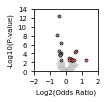


Region: (-25, -15)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


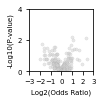

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-15, -6)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


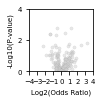


Region: (2, 15)

 Enriched in ALT group: 2
    testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
125      TATA         1.114912        12.024316  2.420603e-10
34       ATAT         0.935239         8.728020  2.394362e-07

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


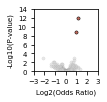

(1022, 12)


In [20]:
kmer = 4
site = 'proximal'
group = 'dapa'
ref_group = 0
alt_group = 2

region_results = []
regions = [v['region'] for k,v in ideal_mot_config.items()]

for region in regions:
    
    ## Load and process data

    dt = (pd.read_csv(os.path.join(MOTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_{region[0]}_{region[1]}.txt'), sep = "\t")
          .replace([np.inf, -np.inf], np.nan).dropna())
    
    dt['odds_ratio_log2'] = np.log2(dt['odds_ratio'])
    dt['pvalue_minlog10'] = -1 * np.log10(dt['pvalue'])
    
    dt['qvalue'] = multipletests(dt['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]
    dt['qvalue_minlog10']  = -1 * np.log10(dt['qvalue'])
    
    dt = dt.replace([np.inf, -np.inf], np.nan).dropna()
    region_results.append(dt)
    
    
    ## Make volcano plot
    
    fig,ax = plt.subplots(1,1, figsize = (1.15,1.15))
    
    sns.scatterplot(data = dt,  x = 'odds_ratio_log2', y = 'pvalue_minlog10', 
                    s = 10, color = 'lightgray', edgecolor = 'darkgray', alpha = 0.5, 
                    rasterized = True, ax = ax)
    
    xlim = math.ceil(max(abs(dt['odds_ratio_log2'])))
    ax.set_xlim((-xlim,xlim))
    ax.xaxis.set_major_locator(MultipleLocator(1))

    ax.set_ylim(0,math.ceil(max(dt['pvalue_minlog10'])/ 2) * 2)
    ax.yaxis.set_major_locator(MultipleLocator(2))
    
    ax.set_xlabel("Log2(Odds Ratio)")
    ax.set_ylabel("-Log10(P-value)")

    ## Annotate plots with significant motifs
    
    print("\nRegion:", region)
    
    cond_sig = (dt['qvalue'] < 0.05)
    pos_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] > 0)]
    neg_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] < 0)]
    
    print("\n Enriched in ALT group:", alt_group)
    print(pos_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    print("\n Enriched in REF group:", ref_group)
    print(neg_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    for i,dtrow in dt.loc[cond_sig].iterrows():
        
        if (dtrow['odds_ratio_log2'] > 0):
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[alt_group], edgecolor = 'black', linewidths = 0.5)
        else:
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[ref_group], edgecolor = 'black', linewidths = 0.5)

    plt.savefig(os.path.join(OUTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_scatter_{region}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()

dapa_results = pd.concat(region_results, ignore_index = True, sort = False)
print(dapa_results.shape)


### Distal sites

#### Tabulate motif positions and frequency in key regions

In [21]:
sig_dist['idxs_EE'] = sig_dist['sequence'].apply(lambda x : motifs.count_motifs(x[:250], ideal_mot_config['EE']['motifs'], overlapping = False, preference = 'max', method = 'equal', count_only = False, index_only = True))
sig_dist['idxs_PE'] = sig_dist['sequence'].apply(lambda x : motifs.count_motifs(x[:250], ideal_mot_config['PE']['motifs'], overlapping = False, preference = 'max', method = 'equal', count_only = False, index_only = True))
sig_dist['idxs_UF'] = sig_dist['sequence'].apply(lambda x : motifs.count_motifs(x[:250], ideal_mot_config['UF']['motifs'], overlapping = False, preference = 'max', method = 'equal', count_only = False, index_only = True))
sig_dist['idxs_DF'] = sig_dist['sequence'].apply(lambda x : 250 + motifs.count_motifs(x[250:], ideal_mot_config['DF']['motifs'], overlapping = False, preference = 'min', method = 'equal', count_only = False, index_only = True))


In [22]:
sig_dist['count_EE'] = sig_dist.apply(lambda row : np.sum([((row['ctr_cleavage']+ideal_mot_config['EE']['region'][0]) <= x <= (row['ctr_cleavage']+ideal_mot_config['EE']['region'][1])) for x in row['idxs_EE']]), axis = 1)
sig_dist['count_PE'] = sig_dist.apply(lambda row : np.sum([((row['ctr_cleavage']+ideal_mot_config['PE']['region'][0]) <= x <= (row['ctr_cleavage']+ideal_mot_config['PE']['region'][1])) for x in row['idxs_PE']]), axis = 1)
sig_dist['count_UF'] = sig_dist.apply(lambda row : np.sum([((row['ctr_cleavage']+ideal_mot_config['UF']['region'][0]) <= x <= (row['ctr_cleavage']+ideal_mot_config['UF']['region'][1])) for x in row['idxs_UF']]), axis = 1)
sig_dist['count_DF'] = sig_dist.apply(lambda row : np.sum([((row['ctr_cleavage']+ideal_mot_config['DF']['region'][0]) <= x <= (row['ctr_cleavage']+ideal_mot_config['DF']['region'][1])) for x in row['idxs_DF']]), axis = 1)


#### Motif counts in each region by usage group

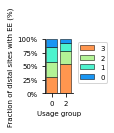

Chi2 test for independence across stress groups
	Groups [0, 2]	9.87E-21


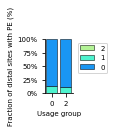

Chi2 test for independence across stress groups
	Groups [0, 2]	5.24E-01


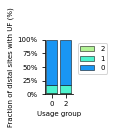

Chi2 test for independence across stress groups
	Groups [0, 2]	4.38E-01


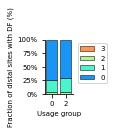

Chi2 test for independence across stress groups
	Groups [0, 2]	3.56E-01


In [23]:
cap = 3
groups = [0,2]

for (cvar,ylim,ytickint) in zip([c for c in sig_dist.columns if (c.startswith('count_'))], [100,20,20,40], [25,5,5,10]):
    
    mvar = cvar.replace('count_','maxcount_')
    
    sig_dist[mvar] = sig_dist[cvar]
    sig_dist.loc[sig_dist[cvar] > cap, mvar] = cap
    
    cdata = sig_dist.loc[sig_dist['sigbinL'].isin(groups)].groupby(['sigbinL',mvar]).size().reset_index(name = 'counts')
    cdata['prop'] = cdata['counts'] / cdata.groupby('sigbinL')['counts'].transform('sum') * 100

    ccounts = cdata.pivot(index = 'sigbinL', columns = mvar, values = 'prop').fillna(0)

    fig,ax = plt.subplots(1,1, figsize = (0.5,1))

    labels = ccounts.index.astype(str).values
    bottoms = np.zeros((len(ccounts)))
    color_list = sns.color_palette('rainbow', cap+1)

    for c in ccounts.columns[::-1]:
        heights = ccounts[[c]].to_numpy().flatten()
        ax.bar(labels, heights, bottom = bottoms, label = c, color = color_list[c], edgecolor = 'black', linewidth = 0.5)
        bottoms = bottoms + heights
    
    ax.set_ylim(0,100)
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))

    ax.set_xlabel("Usage group")
    ax.set_ylabel(f"Fraction of distal sites with {cvar.split('_')[1]} (%)")

    ax.legend(bbox_to_anchor = (1.05,1))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig(os.path.join(OUTDIR, f'presence_elements.by_stress.distal_sites.{mvar}.group_{groups[0]}_vs_{groups[1]}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()


    print("Chi2 test for independence across stress groups")

    cwide = cdata.pivot(index = mvar, columns = 'sigbinL', values = 'counts').fillna(0).to_numpy()
    print(f"\tGroups {groups}\t{st.chi2_contingency(cwide)[1]:.02E}")
    

#### Individual motif enrichment


Region: (-90, -25)

 Enriched in ALT group: 2
     testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
140     ATATAT         1.956617        53.647897  9.009605e-51
139     TATATA         1.672469        46.503757  6.277920e-44
179     TATGTA         1.859406        13.744751  2.402869e-11
141     TATATG         1.457135         7.698999  2.002365e-05
730     ATATGT         1.410729         6.986877  8.255732e-05
905     ATGTAT         1.269330         6.450689  2.364625e-04
180     ATGTAA         1.912052         6.233687  3.340548e-04
1426    ACATAT         1.147444         5.334310  2.318474e-03
1428    TGTATG         1.944214         5.256536  2.465039e-03
196     TAAATA         0.889088         5.059207  3.416095e-03
150     TACATA         0.929680         5.027680  3.416095e-03
588     CATATA         0.944677         4.285173  1.730804e-02
926     ATATAA         0.768073         4.177928  2.023821e-02
567     ATTTAT         0.876821         4.150302  2.023821e-02
1429    

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


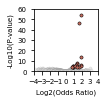

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-25, -15)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


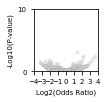

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-15, -6)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


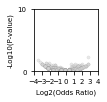

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (2, 15)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


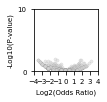

(10653, 12)


In [24]:
kmer = 6
site = 'distal'
group = 'dapa'
ref_group = 0
alt_group = 2

region_results = []
regions = [v['region'] for k,v in ideal_mot_config.items()]

for region in regions:
    
    ## Load and process data

    dt = (pd.read_csv(os.path.join(MOTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_{region[0]}_{region[1]}.txt'), sep = "\t")
          .replace([np.inf, -np.inf], np.nan).dropna())
    
    dt['odds_ratio_log2'] = np.log2(dt['odds_ratio'])
    dt['pvalue_minlog10'] = -1 * np.log10(dt['pvalue'])
    
    dt['qvalue'] = multipletests(dt['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]
    dt['qvalue_minlog10']  = -1 * np.log10(dt['qvalue'])
    
    dt = dt.replace([np.inf, -np.inf], np.nan).dropna()
    region_results.append(dt)
    
    
    ## Make volcano plot
    
    fig,ax = plt.subplots(1,1, figsize = (1.15,1.15))
    
    sns.scatterplot(data = dt,  x = 'odds_ratio_log2', y = 'pvalue_minlog10', 
                    s = 10, color = 'lightgray', edgecolor = 'darkgray', alpha = 0.5, 
                    rasterized = True, ax = ax)
    
    xlim = math.ceil(max(abs(dt['odds_ratio_log2'])))
    ax.set_xlim((-xlim,xlim))
    ax.xaxis.set_major_locator(MultipleLocator(1))

    ax.set_ylim(0,math.ceil(max(dt['pvalue_minlog10'])/ 10) * 10)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    
    ax.set_xlabel("Log2(Odds Ratio)")
    ax.set_ylabel("-Log10(P-value)")

    ## Annotate plots with significant motifs
    
    print("\nRegion:", region)
    
    cond_sig = (dt['qvalue'] < 0.05)
    pos_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] > 0)]
    neg_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] < 0)]
    
    print("\n Enriched in ALT group:", alt_group)
    print(pos_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    print("\n Enriched in REF group:", ref_group)
    print(neg_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    for i,dtrow in dt.loc[cond_sig].iterrows():
        
        if (dtrow['odds_ratio_log2'] > 0):
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[alt_group], edgecolor = 'black', linewidths = 0.5)
        else:
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[ref_group], edgecolor = 'black', linewidths = 0.5)

    plt.savefig(os.path.join(OUTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_scatter_{region}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()

dapa_results = pd.concat(region_results, ignore_index = True, sort = False)
print(dapa_results.shape)



Region: (-90, -25)

 Enriched in ALT group: 2
    testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
131     TATAT         1.389782        54.847783  1.453840e-52
132     ATATA         1.328641        51.029741  4.781111e-49
159     TATGT         1.190530        11.378508  1.141309e-09
160     ATGTA         1.160450        11.350837  1.141309e-09
59      ATATG         0.968350         7.194810  1.307734e-05
146     TGTAT         0.791823         6.964466  1.852180e-05
148     TATAA         0.661096         6.268696  7.879628e-05
147     GTATA         0.775966         6.012982  1.242305e-04
150     TAAAT         0.682897         5.483491  3.737377e-04
183     TTATA         0.607404         5.396575  3.741985e-04
175     TATTT         0.538006         5.395805  3.741985e-04
273     CATAT         0.709328         4.714485  1.646773e-03
337     ATAGA         0.870176         4.594468  2.003960e-03
161     TGTAA         0.896776         4.542289  2.098375e-03
51      AAATA         0

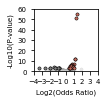

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-25, -15)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


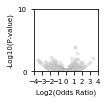

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-15, -6)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


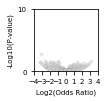

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (2, 15)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


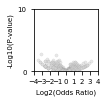

(3901, 12)


In [25]:
kmer = 5
site = 'distal'
group = 'dapa'
ref_group = 0
alt_group = 2

region_results = []
regions = [v['region'] for k,v in ideal_mot_config.items()]

for region in regions:
    
    ## Load and process data

    dt = (pd.read_csv(os.path.join(MOTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_{region[0]}_{region[1]}.txt'), sep = "\t")
          .replace([np.inf, -np.inf], np.nan).dropna())
    
    dt['odds_ratio_log2'] = np.log2(dt['odds_ratio'])
    dt['pvalue_minlog10'] = -1 * np.log10(dt['pvalue'])
    
    dt['qvalue'] = multipletests(dt['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]
    dt['qvalue_minlog10']  = -1 * np.log10(dt['qvalue'])
    
    dt = dt.replace([np.inf, -np.inf], np.nan).dropna()
    region_results.append(dt)
    
    
    ## Make volcano plot
    
    fig,ax = plt.subplots(1,1, figsize = (1.15,1.15))
    
    sns.scatterplot(data = dt,  x = 'odds_ratio_log2', y = 'pvalue_minlog10', 
                    s = 10, color = 'lightgray', edgecolor = 'darkgray', alpha = 0.5, 
                    rasterized = True, ax = ax)
    
    xlim = math.ceil(max(abs(dt['odds_ratio_log2'])))
    ax.set_xlim((-xlim,xlim))
    ax.xaxis.set_major_locator(MultipleLocator(1))

    ax.set_ylim(0,math.ceil(max(dt['pvalue_minlog10'])/ 10) * 10)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    
    ax.set_xlabel("Log2(Odds Ratio)")
    ax.set_ylabel("-Log10(P-value)")

    ## Annotate plots with significant motifs
    
    print("\nRegion:", region)
    
    cond_sig = (dt['qvalue'] < 0.05)
    pos_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] > 0)]
    neg_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] < 0)]
    
    print("\n Enriched in ALT group:", alt_group)
    print(pos_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    print("\n Enriched in REF group:", ref_group)
    print(neg_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    for i,dtrow in dt.loc[cond_sig].iterrows():
        
        if (dtrow['odds_ratio_log2'] > 0):
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[alt_group], edgecolor = 'black', linewidths = 0.5)
        else:
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[ref_group], edgecolor = 'black', linewidths = 0.5)

    plt.savefig(os.path.join(OUTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_scatter_{region}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()

dapa_results = pd.concat(region_results, ignore_index = True, sort = False)
print(dapa_results.shape)



Region: (-90, -25)

 Enriched in ALT group: 2
    testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
103      TATA         0.989937        55.937521  2.956098e-54
50       ATAT         0.924524        48.380009  5.335814e-47
107      TGTA         0.691233        10.889964  1.099398e-09
56       TATG         0.712557         9.167622  4.350690e-08
112      ATGT         0.608145         7.242115  2.931938e-06
73       GTAT         0.532866         6.317389  2.054470e-05
111      TTAT         0.391499         6.235735  2.125237e-05
78       ATAA         0.287267         3.732370  4.309995e-03
97       CATA         0.373603         3.400704  7.756708e-03
108      TAAA         0.271874         2.921410  1.614644e-02
10       TAGA         0.452379         2.895445  1.628416e-02
184      ATAG         0.379782         2.815963  1.862336e-02
24       GTGT         0.497297         2.696577  2.145123e-02
74       TATT         0.233305         2.653227  2.193450e-02
49       AATA         0

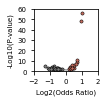


Region: (-25, -15)

 Enriched in ALT group: 2
    testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
103      TATA         1.076815         7.487138  0.000008
107      TGTA         1.081933         4.383546  0.004408
86       TTTT         0.627268         4.286873  0.004408
50       ATAT         0.726768         3.790402  0.010370

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


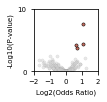


Region: (-15, -6)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


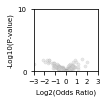


Region: (2, 15)

 Enriched in ALT group: 2
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

 Enriched in REF group: 0
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []


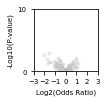

(1024, 12)


In [26]:
kmer = 4
site = 'distal'
group = 'dapa'
ref_group = 0
alt_group = 2

region_results = []
regions = [v['region'] for k,v in ideal_mot_config.items()]

for region in regions:
    
    ## Load and process data

    dt = (pd.read_csv(os.path.join(MOTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_{region[0]}_{region[1]}.txt'), sep = "\t")
          .replace([np.inf, -np.inf], np.nan).dropna())
    
    dt['odds_ratio_log2'] = np.log2(dt['odds_ratio'])
    dt['pvalue_minlog10'] = -1 * np.log10(dt['pvalue'])
    
    dt['qvalue'] = multipletests(dt['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]
    dt['qvalue_minlog10']  = -1 * np.log10(dt['qvalue'])
    
    dt = dt.replace([np.inf, -np.inf], np.nan).dropna()
    region_results.append(dt)
    
    
    ## Make volcano plot
    
    fig,ax = plt.subplots(1,1, figsize = (1.15,1.15))
    
    sns.scatterplot(data = dt,  x = 'odds_ratio_log2', y = 'pvalue_minlog10', 
                    s = 10, color = 'lightgray', edgecolor = 'darkgray', alpha = 0.5, 
                    rasterized = True, ax = ax)
    
    xlim = math.ceil(max(abs(dt['odds_ratio_log2'])))
    ax.set_xlim((-xlim,xlim))
    ax.xaxis.set_major_locator(MultipleLocator(1))

    ax.set_ylim(0,math.ceil(max(dt['pvalue_minlog10'])/ 10) * 10)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    
    ax.set_xlabel("Log2(Odds Ratio)")
    ax.set_ylabel("-Log10(P-value)")

    ## Annotate plots with significant motifs
    
    print("\nRegion:", region)
    
    cond_sig = (dt['qvalue'] < 0.05)
    pos_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] > 0)]
    neg_sig = dt.loc[cond_sig & (dt['odds_ratio_log2'] < 0)]
    
    print("\n Enriched in ALT group:", alt_group)
    print(pos_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    print("\n Enriched in REF group:", ref_group)
    print(neg_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    for i,dtrow in dt.loc[cond_sig].iterrows():
        
        if (dtrow['odds_ratio_log2'] > 0):
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[alt_group], edgecolor = 'black', linewidths = 0.5)
        else:
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = dark_cmap[ref_group], edgecolor = 'black', linewidths = 0.5)

    plt.savefig(os.path.join(OUTDIR, f'dapa_motifs.{site}_sites.{kmer}mers.enrichment_{alt_group}_vs_{ref_group}.region_scatter_{region}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()

dapa_results = pd.concat(region_results, ignore_index = True, sort = False)
print(dapa_results.shape)
